# Import libraries

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np 
import re
import string

from scipy.stats import wilcoxon, mannwhitneyu
from matplotlib.lines import Line2D

In [7]:
def get_jitter_xvals(data, center_x, width, bins=20):
    
    counts, edges = np.histogram(data, bins=bins)

    centres = (edges[:-1] + edges[1:]) / 2.
    yvals = centres.repeat(counts)

    max_offset = width / counts.max()
    offsets = np.hstack(list((np.arange(cc) - 0.5 * (cc - 1)) for cc in counts))
    
    return center_x + (offsets * max_offset)

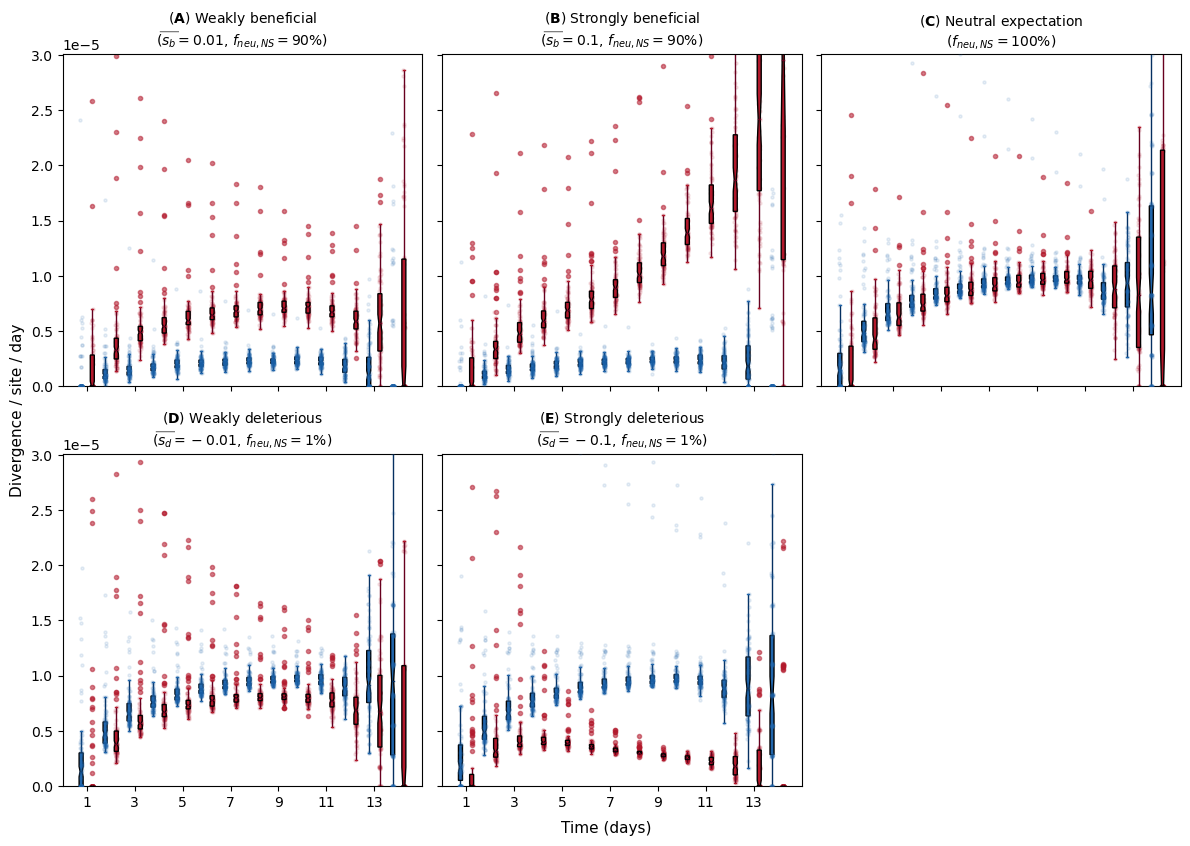

In [5]:
color_dict = {"syn":{'face':'#2166ac', 'faintline':'#2166ac', 'strongline':'#053061'},
              "nonsyn":{'face':'#b2182b', 'faintline':'#b2182b', 'strongline':'#67001f'},}

labsize = 10
days_to_analyze = 14
hours_per_gen = 6
T = int(days_to_analyze*24/hours_per_gen) # number of replication cycles  
t_vec = np.arange(T+1)

parameters_to_print = [("pos", 0.01, 0.9), ("pos", 0.1, 0.9), ("del", 0.0, 1.0), ("del", 0.01, 0.01), ("del", 0.1, 0.01)]

with plt.style.context("default"):
    
    fig, axes = plt.subplots(2, 3, figsize=(11.8, 8.3), sharex=True, sharey=True)
    day_step = int(24/6)
    x_values = t_vec[day_step::day_step]-1
    x_positions = np.arange(0, 3*len(x_values), 3)
    
    for ax_idx, ax in enumerate(axes.flatten()):
        try: 
            s_type, del_s, frac_neu_nonsyn = parameters_to_print[ax_idx]
        except: 
            ax.set_axis_off()
            continue 
    
        fname = "./sim_results/mean_{}_s{}_frac_neu_nonsyn{}.npz".format(s_type, del_s, frac_neu_nonsyn)
        
        all_rate_arr = np.load(fname)['all_rate_arr']
        s_sign = +1 if re.search("pos", fname) else -1

        # synonymous 
        shift = -.7
        c = color_dict["syn"]

        # rate array  
        syn_r_arr = [all_rate_arr[:,0,x-1] for x in x_values]
        #print (syn_r_arr)

        # plot actual data as jitter 
        for idx, yval in enumerate(syn_r_arr):
            ax.scatter(get_jitter_xvals(yval, center_x=x_positions[idx]+shift,  width=0.3), 
                       yval, s=5, c=c['face'], alpha=.1, zorder=100)

        #ax.plot(x_positions+shift, syn_r_arr, lw=0.5, ls="--", c=c["faintline"], alpha=0.1, zorder=-100)
        bp = ax.boxplot(syn_r_arr, positions=x_positions+shift, notch=True,
                        patch_artist=True, sym="",
                        boxprops=dict(facecolor=c['face'], alpha=1.),
                        capprops=dict(color=c['faintline']),
                        whiskerprops=dict(color=c['strongline']),
                        flierprops=dict(markeredgecolor=c['face'], markerfacecolor=c['face'], marker='.', alpha=0.5),
                        medianprops=dict(color=c['strongline']),)
        max_syn = max([item.get_ydata()[1] for item in bp['whiskers']])

        # nonsynoymous
        shift = +.7
        c = color_dict["nonsyn"]
        # rate array  
        #r_arr = [SimResults[:,t,nonsyn_loci].sum(1)/L/(t+1) for t in x_values]
        nonsyn_r_arr = [all_rate_arr[:,1,x-1] for x in x_values]

        # plot actual data as jitter 
        for idx, yval in enumerate(nonsyn_r_arr):
            ax.scatter(get_jitter_xvals(yval, center_x=x_positions[idx]+shift,  width=0.3), 
                       yval, s=5, c=c['face'], alpha=0.1, zorder=-100)
        #ax.plot(x_positions+shift, nonsyn_r_arr, lw=0.5, ls="--", c=c["faintline"], alpha=0.1, zorder=-100)
        bp = ax.boxplot(nonsyn_r_arr, positions=x_positions+shift, notch=True,
                        patch_artist=True,
                        boxprops=dict(facecolor=c['face'], alpha=1.), # color=c['faintline'], 
                        capprops=dict(color=c['faintline']),
                        whiskerprops=dict(color=c['strongline']),
                        flierprops=dict(markeredgecolor=c['face'], markerfacecolor=c['face'], marker='.', alpha=0.5),
                        medianprops=dict(color=c['strongline']),)
        max_nonsyn = max([item.get_ydata()[1] for item in bp['whiskers']])

        """for i, syn_r in enumerate(syn_r_arr): 
            print (i+1, wilcoxon(syn_r, nonsyn_r_arr[i]).pvalue)"""

        # axis labels
        ax.set_ylim(0, max([max_syn, max_nonsyn])*1.1)
        ax.ticklabel_format(style='sci', scilimits=(-2,2), axis='y')
        #ax.set_ylabel("Divergence / site / day", fontsize=12)

        ax.set_xlim((-3., 3*len(x_values)))
        ax.set_xticks(np.arange(0, 3*len(x_values), 6))
        ax.set_xticklabels(np.arange(1, len(t_vec[day_step::day_step])+1, 2))
        #ax.set_xlabel("Day", fontsize=12)

        ax.tick_params(axis="both", labelsize=labsize)
        if frac_neu_nonsyn < 1.:
            ax.set_title(r'($\bf{' + list(string.ascii_uppercase)[ax_idx] + '}$) ' + "{}".format("Weakly" if abs(del_s) < 0.1 else "Strongly") + " {}\n".format("beneficial" if s_sign > 0 else "deleterious") + r'$\widebar{' + "(s_{}".format("b" if s_sign > 0 else 'd') + "}$" + "$={}$, $f_{{neu,NS}}={:.0f}\%$".format(s_sign*del_s if frac_neu_nonsyn < 1. else "na", frac_neu_nonsyn*100) + ")", fontsize=labsize)
        else: 
            ax.set_title(r'($\bf{' + list(string.ascii_uppercase)[ax_idx] + '}$) ' + "Neutral expectation\n($f_{{neu,NS}}=100\%$)", fontsize=labsize)
    
    # x-axis label
    fig.text(-0.005, 0.5, 'Divergence / site / day', va='center', fontsize=labsize*1.1, rotation=90)
    fig.text(0.5, -0.01, "Time (days)", ha='center', fontsize=labsize*1.1)
    
    # legend 
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Synonymous',
                              markerfacecolor='#2b83ba', markersize=12), 
                       Line2D([0], [0], marker='o', color='w', label='Nonsynonymous',
                              markerfacecolor='#d7191c', markersize=12), 
                       Line2D([0], [0], marker='o', color='w', label='Stop',
                              markerfacecolor='#525252', markersize=12)]

    fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(.9, 0.5), fontsize=10)
    
    plt.tight_layout()
    
    plt.savefig("./sims_results_fig.png", dpi=600, bbox_inches = "tight")
    plt.show()